<a href="https://colab.research.google.com/github/Rama-vanapalli/MajorProject/blob/main/InceptionV3_Base_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [6]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data Preparation

batch_size = 128

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Infection Segmentation Data/Infection Segmentation Data/Train',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Infection Segmentation Data/Infection Segmentation Data/Val',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)



Found 8972 images belonging to 3 classes.
Found 557 images belonging to 3 classes.


In [9]:

from tensorflow.keras.applications import InceptionV3


# Directory where the checkpoints will be saved
checkpoint_dir = 'Incep_Models/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a ModelCheckpoint callback to save the model at every improved epoch
checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_train_acc_{accuracy:.4f}_val_acc_{val_accuracy:.4f}.h5'),
    monitor='val_accuracy', # metric to monitor
    verbose=1, # verbosity - 0 or 1
    save_best_only=True, # Save only the best model according to the monitored metric
    mode='max', # Since we are monitoring accuracy, higher is better
    save_weights_only=False # Save the full model, not just the weights
)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1536, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # Assuming 3 classes: normal, violence, adultery

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_score])


# Adjust the `workers` parameter as necessary
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint],
    use_multiprocessing=True,  # <- Enable multiprocessing
    workers=6  # <- Number of workers to use. Adjust as per your CPU cores.
)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 1.1145 - accuracy: 0.5943 - f1_score: 0.5578 
Epoch 1: val_accuracy improved from -inf to 0.66786, saving model to Incep_Models/model_epoch_01_train_acc_0.5943_val_acc_0.6679.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 986s 13s/step - loss: 1.1145 - accuracy: 0.5943 - f1_score: 0.5578 - val_loss: 0.7885 - val_accuracy: 0.6679 - val_f1_score: 0.5835
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 0.6455 - accuracy: 0.6909 - f1_score: 0.6657
Epoch 2: val_accuracy improved from 0.66786 to 0.72352, saving model to Incep_Models/model_epoch_02_train_acc_0.6909_val_acc_0.7235.h5
71/71 [==============================] - 230s 3s/step - loss: 0.6455 - accuracy: 0.6909 - f1_score: 0.6657 - val_loss: 0.6520 - val_accuracy: 0.7235 - val_f1_score: 0.6795
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.6349 - accuracy: 0.6936 - f1_score: 0.6826
Epoch 3: val_accuracy improved from 0.72352 to 0.73609, saving model to Incep_Models/model_epoch_03_train_acc_0.6936_val_acc_0.7361.h5
71/71 [==============================] - 243s 3s/step - loss: 0.6349 - accuracy: 0.6936 - f1_score: 0.6826 - val_loss: 0.6512 - val_accuracy: 0.7361 - val_f1_sco

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 127, 127, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 127, 127, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 127, 127, 32)         0         ['batch_normalization_94

In [11]:
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, to_file='IncepV3_model.png', show_shapes=True, show_layer_names=True)


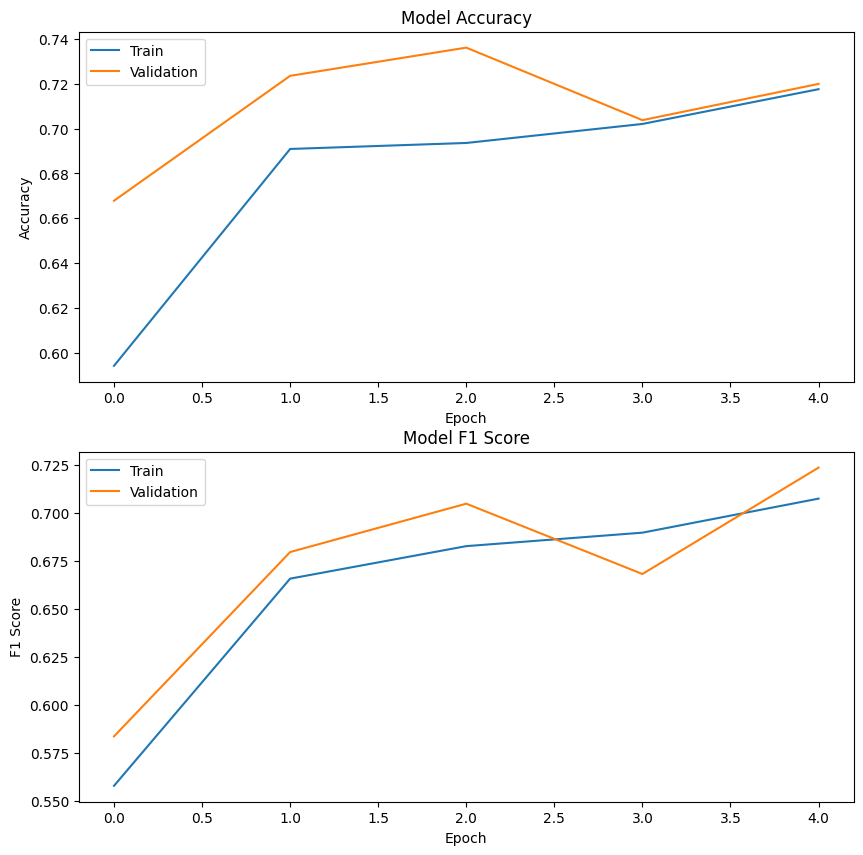

In [13]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable that holds the output of the fit function
# e.g., history = model.fit(...)

# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 10))  # 2 rows, 1 column

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation F1 score values
axs[1].plot(history.history['f1_score'])
axs[1].plot(history.history['val_f1_score'])
axs[1].set_title('Model F1 Score')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')


# Save the figure
plt.savefig('IncepV3_Graph.png')

# Close the figure to avoid displaying it in the notebook output
#plt.close()
